In [37]:
import yfinance as yf 
import statsmodels.api as sm 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  
import numpy as np 

from statsmodels.stats.outliers_influence import variance_inflation_factor 
from statsmodels.stats.stattools import durbin_watson 
from sklearn.metrics import mean_squared_error

## Download the data from YF

In [38]:
tickers = ['AAPL', 'AMZN', 'MSFT', 'QQQ', '^GSPC']
df = yf.download(tickers, start= '2020-01-01', end= '2024-12-31')['Close']
#df.head()

C:\Users\Startklar\AppData\Local\Temp\ipykernel_23296\71036362.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start= '2020-01-01', end= '2024-12-31')['Close']
[*********************100%***********************]  5 of 5 completed


## Feature Engineering

In [39]:
#Yesterday's values
df['AAPL(t-1)'] = df['AAPL'].shift(-1)
df['AMZN(t-1)'] = df['AMZN'].shift(-1)
df['MSFT(t-1)'] = df['MSFT'].shift(-1)
df['QQQ(t-1)'] = df['QQQ'].shift(-1)
df['^GSPC(t-1)'] = df['^GSPC'].shift(-1)

#Moving Average (MA): Indicator for short term trend 
df['AAPL_MA_5'] = df['AAPL'].rolling(window = 5).mean()
df['AMZN_MA_5'] = df['AMZN'].rolling(window = 5).mean()
df['MSFT_MA_5'] = df['MSFT'].rolling(window = 5).mean()
df['QQQ_MA_5'] = df['QQQ'].rolling(window = 5).mean()
df['^GSPC_MA_5'] = df['^GSPC'].rolling(window = 5).mean()

#Target variable 
df['Target'] = df['AAPL'].shift(-1)

df = df.dropna()


In [40]:
df.columns

Index(['AAPL', 'AMZN', 'MSFT', 'QQQ', '^GSPC', 'AAPL(t-1)', 'AMZN(t-1)',
       'MSFT(t-1)', 'QQQ(t-1)', '^GSPC(t-1)', 'AAPL_MA_5', 'AMZN_MA_5',
       'MSFT_MA_5', 'QQQ_MA_5', '^GSPC_MA_5', 'Target'],
      dtype='object', name='Ticker')

## Linear Regression Model - Ordinary Least Square

### Training 

In [41]:
#Set X and Y variable for linear regression model - Ordinary Least Square (OLS) 
# Y = Intercept +  B1*X1 + B2*X2 + B3*X3

X = df[['AAPL(t-1)', 
        #'AAPL_MA_5', 
        '^GSPC(t-1)'
        ]]
Y = df['Target']

X_const = sm.add_constant(X) #Intercept
model = sm.OLS(Y, X_const).fit() #Train the model
model.summary() #Summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Target   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.735e+30
Date:                Wed, 08 Oct 2025   Prob (F-statistic):               0.00
Time:                        15:05:17   Log-Likelihood:                 33397.
No. Observations:                1252   AIC:                        -6.679e+04
Df Residuals:                    1249   BIC:                        -6.677e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.337e-13   1.27e-13      2.637      0.008    8.55e-14    5.82e-13
AAPL(t-1)      1.0000   1.19e-15   8.43e+14      0.000       1.000       1.000
^GSPC(t-1)  1.159e-16   6.46e-17      1.795      0.073   -1.08e-17    2.43e-16
==============================================================================
Omnibus:                       74.857   Durbin-Watson:                   0.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               53.511
Skew:                          -0.400   Prob(JB):                     2.40e-12
Kurtosis:                       2.380   Cond. No.                     3.08e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.08e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Testing

In [42]:
df_train_predict = pd.DataFrame()
df_train_predict['Actual'] = df['Target']
df_train_predict['Predicted'] = model.predict(X_const)
#df_train_predict.head()

### Plotting

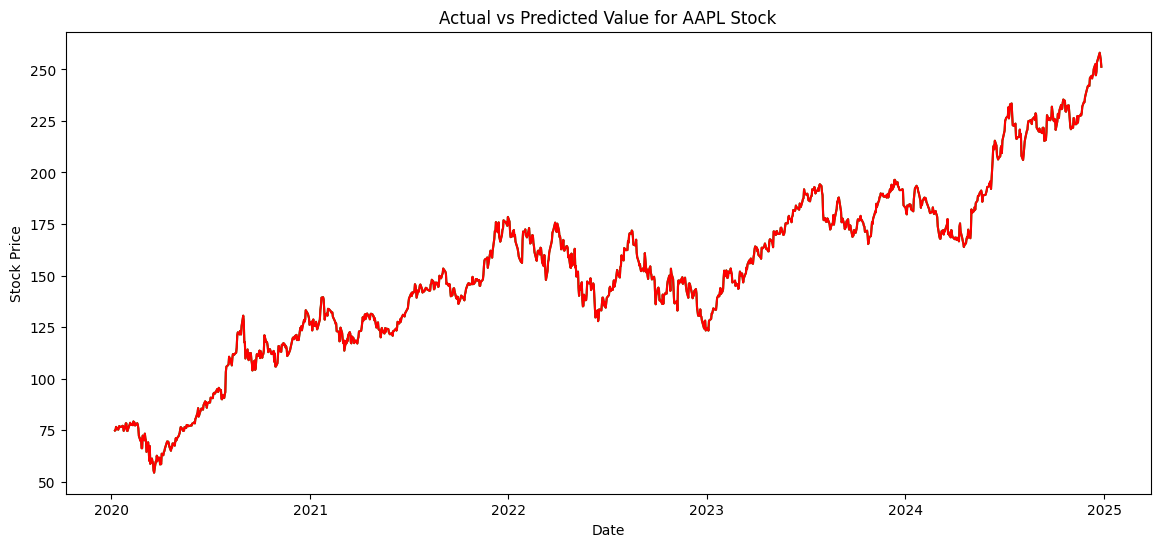

In [43]:
plt.figure(figsize = (14,6))
plt.plot(df_train_predict.index, df_train_predict['Actual'], label = 'Actual', color = 'green')
plt.plot(df_train_predict.index, df_train_predict['Predicted'], label = 'Predicted', color = 'red')
plt.title("Actual vs Predicted Value for AAPL Stock")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()

## Testing Linear Regression Assumptions

### Linearity between variables

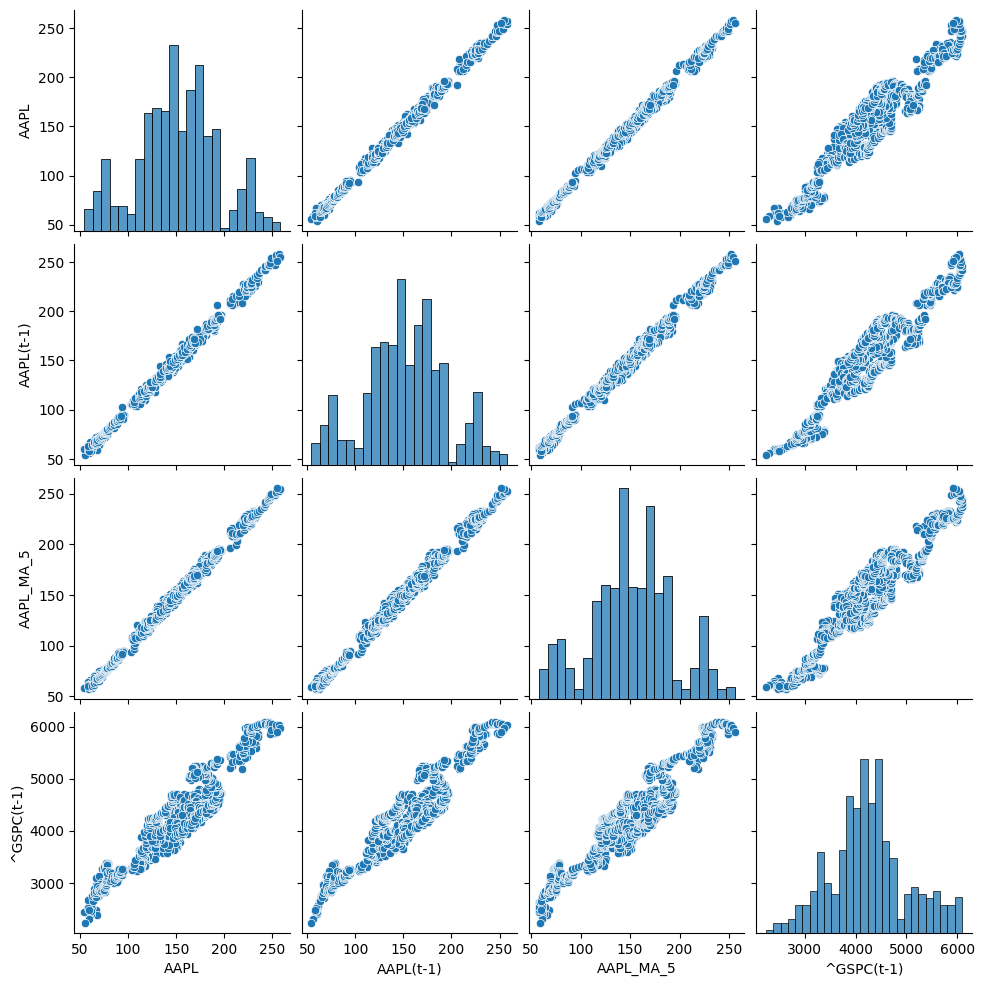

In [44]:
#First Assumption: Linearity between dependent and independent variables 

df = df [['AAPL', 'AAPL(t-1)', 'AAPL_MA_5', '^GSPC(t-1)']]
sns.pairplot(df)

#Only look at 'AAPL' row and check if linear with other variables ! 

### Homoscedascity

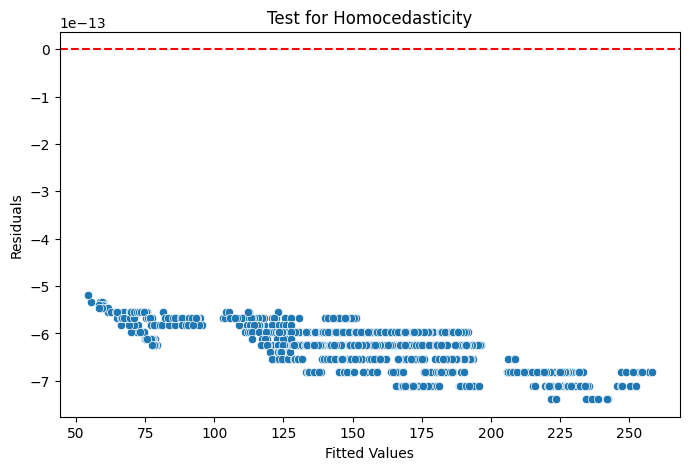

In [45]:
#2nd Assumption: Homoscedasticity: Fitting Residual with the predicted value 

residual = model.resid #Actual - Predicted 
fitted = model.fittedvalues #Predicted Y value 

plt.figure(figsize = (8,5))
sns.scatterplot(x = fitted, y = residual)
plt.axhline(0, color = 'red', linestyle = '--')
plt.title('Test for Homocedasticity')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

#Tube like structure => Homoscedastic 
#Funnel like structure => Heteroscedastic

### Multicolinearity

In [46]:
#3rd Assumption: Multicolinearity => VIF (Variance Inflation Factor), only used for independent variables

#Rule of thumb:
#VIF < 1 => No multicolinearity 
#VIF < 10 => Moderate multicolinearity 
#VIT > 10 => Strong multicolinearity

vif = pd.DataFrame()
vif['Features'] = X_const.columns #we don't consider ['AAPL']
vif['VIF'] = [variance_inflation_factor(X_const.values, i) for i in range(X_const.shape[1])]
vif = vif[1:]
vif

,Features,VIF
1,AAPL(t-1),7.69072
2,^GSPC(t-1),7.69072


### Normality of Residual 

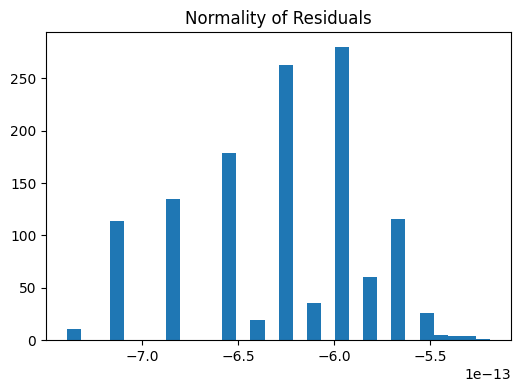

In [47]:
#4th Assumption: Normality of Residual => Visual Test (Histogram) or QQ plot

plt.figure(figsize = (6,4))
plt.hist(residual, bins=30)
plt.title("Normality of Residuals")
plt.show()

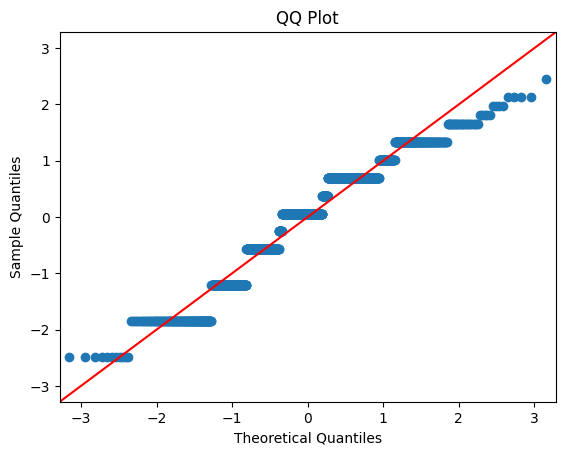

In [48]:
##QQ Plot: Testing for normality of residuals
sm.qqplot(residual, line = '45', fit = True)
plt.title('QQ Plot')
plt.show()

### Auto-correlation of residual: Durbin Watson Test

In [49]:
#5th Assumption: Auto correlation of Residual: Durbin Watson Test 

dw = durbin_watson(residual)
dw #p value 

# p value < 0.05 => Autocorrelation b/w residual is there 
# p value > 0.05 => Autocorrelation b/w residual is not there 


###ALL CONDITIONS ARE MET 

np.float64(0.0003235684183385555)

## Let's predict 2025 market price

### Download data

In [50]:
tickers = ['AAPL', '^GSPC']
df = yf.download(tickers, start = '2025-01-01', end = '2025-03-31')['Close']
df.head()

C:\Users\Startklar\AppData\Local\Temp\ipykernel_23296\4176375428.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(tickers, start = '2025-01-01', end = '2025-03-31')['Close']
[*********************100%***********************]  2 of 2 completed


Ticker,AAPL,^GSPC
Date,,
2025-01-02,242.987411,5868.549805
2025-01-03,242.499146,5942.470215
2025-01-06,244.133347,5975.379883
2025-01-07,241.353210,5909.029785
2025-01-08,241.841476,5918.250000


### Data engineering

In [51]:
#Data Engineering: 

df['AAPL(t-1)'] = df['AAPL'].shift(1)
df['^GSPC(t-1)'] = df['^GSPC'].shift(1)
df = df.dropna()
df.head()

Ticker,AAPL,^GSPC,AAPL(t-1),^GSPC(t-1)
Date,,,,
2025-01-03,242.499146,5942.470215,242.987411,5868.549805
2025-01-06,244.133347,5975.379883,242.499146,5942.470215
2025-01-07,241.353210,5909.029785,244.133347,5975.379883
2025-01-08,241.841476,5918.250000,241.353210,5909.029785
2025-01-10,236.012192,5827.040039,241.841476,5918.250000


### Linear Regression Variables

In [52]:
X_test = df[['AAPL(t-1)', '^GSPC(t-1)']] #Independent Variables
X_test = sm.add_constant(X_test)

df_result = pd.DataFrame()
df_result['Actual'] = df['AAPL']
df_result['Predicted'] = model.predict(X_test)
#df_result

### Plotting

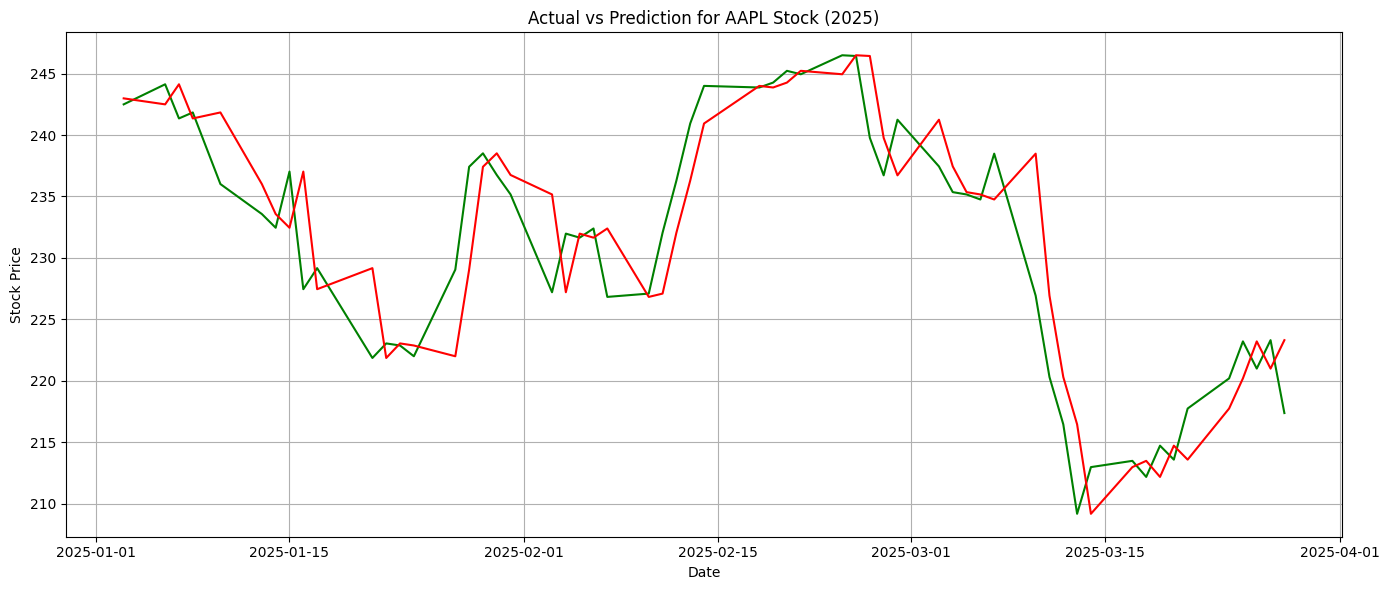

In [53]:
plt.figure(figsize = (14,6))
plt.plot(df_result.index, df_result['Actual'], label = 'Actual', color = 'green')
plt.plot(df_result.index, df_result['Predicted'], label = 'Predicted', color = 'red')
plt.title("Actual vs Prediction for AAPL Stock (2025)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.tight_layout()
plt.grid(True)
plt.show()

P value < 0.05 => Variable is significant => KEEP IT ;  
P value > 0.05 => Variable is not significant => DROP IT 

Conclusion: Decent model but not 100% accurate 

=> Stock data have lot of non linearities => Very tough to capture non linear affect => We use ML models which are better at capturing non linearities. 

### Calculate Root Mean Square Error & Mean Square Error

In [54]:
#Calculate rmse & mse 
# root mean square error => Sqr root ( Avg( (A - P)^2 ) )

mse = mean_squared_error(df_result['Actual'], df_result['Predicted'])
rmse = np.sqrt(mse)
print(rmse, mse)

#RMSE = alpha => The predicted stock price are, on average, off by $ alpha from the actual price 

4.151621421124568 17.235960424340373
